# Code Overview and Troubleshooting 

## Table of Contents

### Goals of this document 

### Paper Overview 

### Code Methodology 

### Code Walkthrough 

### Troubleshooting and Debugging 

### Goals of this document 

* What: The purpose of this document is to succintly explain the code and related methodology in "Ligand Strain Energy in Large Library Docking" in a coherent and straightforward manner to support our usage of this strain methodology in our virtual screening work. 

* Why: At the present moment, it is difficult to trust the use of this code because of several factors:

1. No native support for SDF files. 

The code has native support for the use of mol2 or db2 file types, but not sdf. In theory, this should not be an issue. The primary difference between mol2 and sdf is typically the ability to have partial charge information (in the mol2 file type). In theory, their calculation of torsion strain does not rely on anything but the atom types involved in the dihedral angle being analyzed and their 3D coordinates. However, practically, there are issues. I can't succinctly describe them as I am still trying to better understand the code. At a high level, the issue has to do with file conversions. Considering that the output of our VS is typically sdf, we either need to convert our sdf to mol2 and use the native function, or develop an equivalent function to their mol2/db2 input function that will take a native sdf file. 

What I have noticed here, is that neither approach can perfectly recreate the example output csv of torsion energies. This is complicated by the fact that there are only 3 example molecules given by the authors, which limits how throughly one could test the results of troubleshooting this problem. I will cover both approaches and the nuances.

2. Full understanding of the code. 

While I can explain at a high level what the code does, debug various aspects of it, refactor various components, and so on, the logic involved in selecting the torsion is difficult to follow. If I had a strong fundamental understanding of the code, it would be easier to understand. Ideally, this document will serve other members of our group well that could troubleshoot this code, without having to repeat the work I've done. 

* How: This document will first go through the methodology written in the paper, as well as the code provided to future users and attempt to succinctly explain how it works. This will be followed by the debugging section, in which I show what attempts I have made towards the file conversion issue. 

### Paper Methodology Overview:

This paper seeks to create an energy profile for a given conformer based on comparison of it's torsions to a pre-computed library of torsion energies.

The authors first describe the torsion library:

`Torsion Library Generation
We represent every sequence of four atoms defining a dihedral angle by a torsion pattern using the SMARTS line notation. (30) We adapted the torsion library of Rarey et al. (24,25) to build our own library, which has 514 torsion patterns with the same hierarchical organization as the original. Each torsion pattern has a histogram of the observed counts for each possible dihedral angle measurement in the CSD and PDB. For each torsion pattern’s histogram, if the total count is less than 100, we use an approximate approach. The original torsion library allows “tolerances” about each peak in the histogram, where the observed frequency drops below a certain value. Our approximate approach flags any degree difference between a conformation’s dihedral angle and the histogram’s peak that is larger than the maximum tolerance in the original library. If the total count is larger than 100, we convert the histogram frequencies into torsion energy units (TEUs) by applying the Boltzmann equation (Figure S1), which we term the “exact approach”. To avoid infinite energies from zero counts in the histograms, we add the minimum positive count from each histogram to any zero counts. We assume that the original measurements from the CSD and PDB exist in a canonical ensemble at 298 K, meaning the temperature of the hypothetical ensemble is a tunable parameter in creating the strain energy library. We therefore use TEU instead of kcal/mol to reflect the fact that our energy scale is artificial and based on the databases’ sampling of the hypothetical ensemble. We modeled this unit on Rosetta’s use of Rosetta energy units in its scoring function for protein structure conformational energy. (32,33)`

So far, this is mostly straightfoward. They are computing the 'torsion energy units' of a given 'torsion pattern' based on how often they have been observed in the CSD/PDB. The basic logic (as I understand) is: if the torsion found in your molecule is observed often in the crystallographic datasets, it is assumed to be lower in energy. If it not observed often, it is likely higher in energy. There are two ways that the energy is actually calculated, as either "exact" or "approximate". If observations ('total counts') are large (this pattern has been seen >100 times), they use an exacty method via the Boltzmann equation. If it is not observed very often, they use an "approximate" approach. Both calculation methods are in the code itself, so we'll cover how this works there. 

This part of the code and paper does not seem to be involved in the issues I am having, but it is worth describing to better understand what's going on. 

Then, this library is used like so: 

`
The current version can handle two types of input files: mol2 and db2 (a format for DOCK3.7). (34) With the energy profile for each torsion pattern precalculated in the library, we only need to look up the energy estimates for the torsion patterns present in the molecule and not calculate them from scratch. Using the Chem submodule in the Python module RDKit, (35) we find all of the torsion patterns present in the molecule based on their SMARTS patterns, calculate their dihedral angles, and then extract the relevant energy estimates from the torsion library. We keep the information matching the most specific (least general) torsion pattern in the library’s hierarchy. Then, we can sum the energy estimates for all of the torsion patterns to get the estimate for the molecule’s conformation or simply find the torsion patterns with energy estimates above the desired cutoff (Figure 1).`

This part of the methodology is where I think the issues arise. The methods here are not very descriptive beyond saying: (1) SMARTs patterns define the torsion pattern, (2) we get the torsion energies for these patterns, (3) we keep the information matching the most specific torsion pattern, (4) we can sum the energies of all the torsion patterns together. This is shown in Figure 1. 

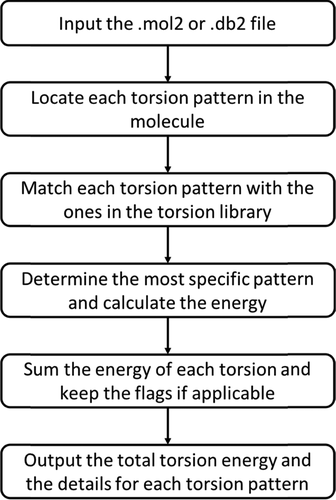

The issue here is that the actual python code that handles keeping the torsions is more complex than this. 



### Code Methodology 

#### Relevant Files

The relevant section of the code/data we need are in three parts: 

`TL_2.1_VERSION_6.xml`

This is the xml file containing the torsion patterns. We will examine this as it is relevant to how the code functions, specifically we are interested in how this xml is traversed because it will set a variable that is used to select one torsion pattern over another. 

`Torsion_Strain.py`

This is the 'executable' part of the code. It reads in functions that are in `TL_functions.py` and uses them to write a csv. There isn't a huge amount of logic in this actual code beyond writing the CSV itself. We will go through this. 

`TL_functions.py` 

This is difficult part of the code. To me, the most confusing aspect of this code has to do how torsion patterns are "filtered" so they can be reported in `Torsion_Strain.py`

#### Workflow 

At a high level, the code works like this. `Torsion_Strain.py` calls `TL_Functions.py` in order to get the data to write the csv using the `TL_lookup(mol)` function. `TL_lookup(mol)` returns a `TP_list` class. This class contains the data that is reported for a given molecule when `Torsion_Strain.py` writes the csv.

`TL_lookup(mol)` calls other functions in `TL_Functions.py`, notably `tp_match(tp, hc, j, mol, pos, bi)`. This part of the code is also challenging. The other functions are relatively straightforward and handle cancluating angles, normalizing values, and so on. 

We will walk through what happens to a molecule when it is passed into TL_lookup() to give us our output CSV. 

#### Walkthrough 



1. CSV Generation: 

The csv is written like this in `Torsion_Strain.py` (direct quote, original comments)

```py

file_name = output_name + "_Torsion_Strain.csv"
with open(file_name, mode = "w") as file_out:
    # Initialize the output file
    file_writer = csv.writer(file_out) #Initialize writing with csv, using
    # https://realpython.com/python-csv/ as a guide
    count = 0
    for name in names: #Loop over every molecule in the list
        mol = ms[name] #Get the molecule with that name
        if mol is not None: #Check to make sure the molecule exists
            try:
                M = TL_lookup(mol) #Create a TP_list function
                mol_est = []
                mol_est += M.sum(0)
                mol_info = M.get_TPs() #The molecule's information
                bond_info = [item for sublist in sorted(mol_info, key = lambda l:l[1], reverse=True) for item in sublist]
                # Unlist the list of lists into just a list of elements
                file_writer.writerow([name] + mol_est + bond_info)
                # Add the list as a row
            except:
                count += 1
                file_writer.writerow([name] + ["NA"])
    file_out.close()

```

This is pretty straightforward. At the try statement, we create `M` a `TP_list` object. We start a list called `mol_est`, we sum the energies (this sum function is specific to this class, not a generic python function). We use the `get_TPs()` method to get the information for a subset of torsion patterns and save it as mol_info. We flatten that mol_info in the next line, `bond_info`.

The `bond_info` variable works like so: It flattens `mol_info` into a single list `bond_info`, sorting the sublists in `mol_info` in descending order based on their second element. This how we get the output we see in the CSV. Then we write the name, the sum of energies (mol_est) and torsion pattern information to a line in the csv and we continue to the next mol object.

From here we can see that `TL_lookup(mol)` creates a `TP_list` class, that has functions `.sum()` (total energy) and `.get_TPs()` (information about the torsion pattern). This is ultimately what gives you the data for a given mol. Both `.sum()` and `get_TPs()` are complex functions but neither governs the logic of which torsion patters are kept, which is the discrepency I am seeing, so I will skip over them for now. 

We'll start instead at `TL_lookup()`. It's a long function, and it will call `tp_match()`, so we'll do it in parts. 

```py 

def TL_lookup(mol): #mol is read in from the .mol2 file
    positions = mol.GetConformer().GetPositions()
    # List of lists of atom coordinates. Luckily RDKit starts indexing at 0
    bond_info = []
    # Initialize an empty list that will hold the information for each bond
    i = 0 #Initialize count of torsion rules

    # Loop over all of the specific hierarchy classes
    for HC in root.findall("hierarchyClass"):
        if HC.get("name") != "GG": #Not the general class
            for TP in HC.iter("torsionRule"): #Loop over each torsion rules
                tp_match(TP, "specific", i, mol, positions, bond_info)
                i += 1 #Increase the count for the torsion rule

    # Now for the general method:
    for TP in root.find("hierarchyClass[@name='GG']").iter("torsionRule"):
        tp_match(TP, "general", i, mol, positions, bond_info)
        i += 1 #Increase the count for the torsion rule

```

First we get the positions of our rdkit mol object using rdkit functions `mol.GetConformer().GetPositions()`. We make any empty `bond_info` list. We make a counter, `i`, to count the torsion rules. We then loop through the xml, we start with the not GG types of torsions in the xml (not the general classes). We loop through the torsionRules, which are smarts patterns. Here's what that can look like in the xml. 

```xml 

<hierarchyClass id1="C" id2="O" name="CO">
    <hierarchySubClass name="Ester bond I" smarts="O=[C:2][O:3]">
      <torsionRule method="exact" smarts="[O:1]=[C:2]!@[O:3]~[CH0:4]">

```

Here 'name' is "CO". The torsionRule has the calculation method (exact or approximate) and the smarts pattern for that torsion. We call tp_match on every torsion rule. After we do so, we will increment `i` so that we can keep track of how far we've searched, which will be important for filtering torsions.

We will then call tp_match() for the general torsions in a very similar way. The only change is that we will use "general" as an argument here, whilwe used specific the first time. This is to keep track of whether or torsion is associated with a "specific" or a "general" match. Here's an example of a general torsion. 

```xml
<library>
  <hierarchyClass id1="G" id2="G" name="GG">
    <torsionRule method="exact" smarts="[*:1]~[CX4:2]!@[n:3]~[*:4]">
```

Note that the calculation method (method="exact" or method="approximate")is different than whether something is `specific` or `general`, the specificity of the match is determined by the SMARTS pattern. 

`tp_match()` is also long. so we'll analyze it in parts, and then get back to `TL_lookup()`. It is unfortunately written in somewhat of a strange order. It is also not written like I am used to, there are no return statements.

```py

def tp_match(tp, hc, j, mol, pos, bi):
    # tp is a torsion pattern, hc is the type of hierarchyClass ("general" or
    # "specific", and j is the current value for i
    # This function turned the global variables mol, positions, and bond_info
    # in TL_Lookup_Test.py into parameters mol, pos and bi, respectively
    smarts = tp.get("smarts")
    # Create the histograms for energy estimates and bounds of confidence
    # intervals, if available
    hist_E = [] #Initialize for energy estimates
    hist_l = [] #Initialize for lower bounds of CIs
    hist_u = [] #Initialize for upper bounds of CIs
    if tp.get("method") == "exact":
        for bin in tp.find("histogram_converted").findall("bin"):
            hist_E.append(float(bin.get("energy")))
            hist_l.append(float(bin.get("lower")))
            hist_u.append(float(bin.get("upper")))
    matches = mol.GetSubstructMatches(Chem.MolFromSmarts(smarts))

```

So, first we get the smarts in that torsionRule using `.get()`. It then handles finding the energies for the exact method (if that is true). We don't really need to worry about that right now. What is important is that we set the `matches` variable by getting the `smarts` and asking what subtructures in the mol object (what we called `TL_lookup()` on) match this smarts? 

Now, we're gonna start filtering our matches. 


```py 

# A list of lists
    for match in matches: #For each match
        # Some of the SMARTS for the torion patterns actually have 5 atoms.
        # We need to ingore these
        if len(match) > 4:
            continue #Go to the next match

        if mol.GetAtomWithIdx(match[0]).GetSymbol()=='H' or mol.GetAtomWithIdx(match[3]).GetSymbol()=='H':
            continue

```

Here, we are just filtering if the torsion pattern has 5 atoms (torsion is only valid for 4, not sure why/how his library has cases with 5 atoms). Then, if the first or last atom is a hydrogen, we skip it (we need non hydrogen atoms at the ends of the bond to do torsion energy). 

A large portion of this code then handles how the energies are ultimately calculated. We will return to this later. First, let's revisit what this function takes as an argument: 

```py 
def tp_match(tp, hc, j, mol, pos, bi)
```
`tp` gave us the smarts, `hc` was already set when this called in `TL_lookup()`, `j` is `i` in `TL_lookup()`, `mol` is the same mol as in `TL_lookup()`, pos is found in `TL_lookup()` at the very beginning. Now we have `bi` (this will be bond_info later):

```py 
     bi.append(
            [
            list(match), #Convert tuple to list
            theta,
            smarts,
            hc, #"general" or "specific"
            "exact",
            energy,
            lower,
            upper,
            False, #This only could apply for the approximate method
            j #We will take this out when we create the final object
            ]
            )

```

or 

```py

            bi.append(
            [
            list(match), #Convert tuple to list
            theta,
            smarts,
            hc, #"general" or "specific"
            "approximate",
            energy,
            energy, #Lower bound for CI, which we cannot find for approx. method
            energy, #Upper bound for CI, which we cannot find for approx. method
            not_observed,
            j #We will take this out when we create the final object
            ]
            )

```

Let's revisit where we left off in `TL_lookup()`

```py
def TL_lookup(mol): #mol is read in from the .mol2 file
    positions = mol.GetConformer().GetPositions()
    # List of lists of atom coordinates. Luckily RDKit starts indexing at 0
    bond_info = []
    # Initialize an empty list that will hold the information for each bond
    i = 0 #Initialize count of torsion rules

    # Loop over all of the specific hierarchy classes
    for HC in root.findall("hierarchyClass"):
        if HC.get("name") != "GG": #Not the general class
            for TP in HC.iter("torsionRule"): #Loop over each torsion rules
                tp_match(TP, "specific", i, mol, positions, bond_info)
                i += 1 #Increase the count for the torsion rule

    # Now for the general method:
    for TP in root.find("hierarchyClass[@name='GG']").iter("torsionRule"):
        tp_match(TP, "general", i, mol, positions, bond_info)
        i += 1 #Increase the count for the torsion rule
```

Now we see that `tp_match` searches the xml for smarts patterns, starting as specific, then at general. If it doesn't find a match (`matches` has no elements), it will still increment the count, but the for loop can't execute, and bond_info will remain unchanged. 

Further, we can see that we query all the potential smarts patterns in the xml against the mol object that TL_lookup() is used on. 

`bond_info` and it's structure is going to be important to understand. 

I added print statements in my `refactor_TL_Functions_debug.py` script, like so: 

```py

    print(f"[TL_lookup] type of bond_info: {type(bond_info)}")
    print(f"[TL_lookup] Number of lists in bond_info: {len(bond_info)}")
    print(f"[TL_lookup] Number of items in first bond: {len(bond_info[0])}")

```

`bond_info` is very large, so I will report the stuff that describes it first:

[TL_lookup] type of bond_info: <class 'list'>
[TL_lookup] Number of lists in bond_info: 40
[TL_lookup] Number of items in first bond: 10

As we can see, `bond_info` is a list of lists. There are 40 lists within it. Those are all the torsion patterns and associated strain data we have matched for that molecule. The only filtering that can happen so far is excluding those with >4 atoms and terminal hydrogens. Each of those 40 lists has 10 items in it. The number of lists can change, based on how many torsions are matched to that specific mol when tp_match() is called. However, it will always have 10 items within those variable amount of lists. We can look at one here: 

```py

for index, bond in enumerate(bond_info):
        print(f"[TL_lookup] Bond {index}: {bond}")
        print(f"[TL_lookup] Number of items in bond: {len(bond)}")

```
This for loop goes through the lists and let's us print out the 40 sublists individually. Here are the first two, for example. 

[TL_lookup] Bond 0: [[18, 23, 24, 26], -179.99349340619358, '[a:1][a:2]!@[NX3:3][!#1:4]', 'specific', 'exact', 0.0002475159675178751, -0.011782303262766858, 0.012522277005268923, False, 175]
[TL_lookup] Number of items in bond: 10
[TL_lookup] Bond 1: [[22, 23, 24, 26], 0.44585819818713934, '[a:1][a:2]!@[NX3:3][!#1:4]', 'specific', 'exact', 0.04286473150482756, 0.029821344396192107, 0.056205983956472805, False, 175]

The ten elements within the list are: 

1) The smarts pattern match as a tuple of atom indexes. 
2) theta, the angle found for that pattern in your molecule
3) the smarts pattern from the xml tree that was found in your molecule
4) The hierarchy class it belongs to in the XML ('specific' or 'general'). 
5) The calculation method used to get the energy ('exact' or 'approximate')
6) the strain energy 
7) the lower bound confidence of the energy (if the approximate method calculated the strain energy, it simply gives the energy again, as they don't have confidence intervals)
8) the upper bound confidence of the energy (if the approximate method calculated the strain energy, it simply gives the energy again, as they don't have confidence intervals)
9) a flag, that is used in the `.sum()` method in the `TP_list` class. (As far as I understand). By default, if tp_match() finds something with the "exact" calculation method this will be false. If the approximate method is used, it could be true based on a condition about angle tolerances. If a true flag is triggered, it seems to assign the molecule a negative energy proportional to the flags. I don't get why he would do that, but even if that happens - the molecule is still written to the csv, so it is also not involved in the torsion filtering. 
10) `i` (also `j`, I think), which is how far patterns were checked for by the time it found a pattern in your molecule. This will be later used for filtering. 


Now, we need to figure out the challenging part, the filtering of torsions patterns that is happening in `TL_lookup()`, let's continue going through that function. 

```py 

# Now that we have all of the torsion patterns, we need to be able to find
    # duplicates. The first such way is if the entire pattern is reversed. We
    # can fix this problem by making sure that all of the lists of indeces have
    # the second index (the first in the bond of interest) lower than the third
    # index (the second in the bond of interest)
    for  bond in bond_info: #Loop over every bond
        if bond[0][1] > bond[0][2]:
            bond[0].reverse() #Reverse this list
            bond.append(True) #Mark that we reversed this bond's indeces
        else:
            bond.append(False) #Mark that we did not reverse this bond's
            # indeces. We will remove this marking later

```

This starts right after all the torsions are found and added as `bond_info`. `bond` is those set of ten elements I described above. 

Here, his comments describe it reasonably well. But I can show an example of what's happening with these print statements. A really tricky thing to notice (for me at least), is that this code is reversing bond in place. 

```py

for bond in bond_info:
        print(f"[TL_lookup] bond[0][1]: {bond[0][1]}")
        print(f"[TL_lookup] bond[0][2]: {bond[0][2]}")
        if bond[0][1] > bond[0][2]:
            print(f"[TL_lookup] {bond[0][1]} > {bond[0][2]}")
            print(f"[TL_lookup] Reversing bond: {bond}")
            bond[0].reverse()
            print(f"[TL_lookup] Reversed bond: {bond}")
            bond.append(
                True
            )  # despite modifying 'bond', it modifies this list in place in bond_info
        else:
            bond.append(False)

```

So here's `bond` that will trigger this: 

[TL_lookup] Bond 2: [[9, 8, 6, 10], -59.99827151843282, '[OX2:1][CX4:2]!@[CX4:3][N:4]', 'specific', 'exact', 0.01598285324959059, -0.03286993469690691, 0.06738657722312391, False, 252]



[TL_lookup] 8 > 6
[TL_lookup] Reversing bond: [9, 8, 6, 10]
[TL_lookup] Reversed bond: [10, 6, 8, 9]

This does seem to work just as he describes. As we see this bond trigger it next:

[TL_lookup] Bond 7: [[9, 8, 6, 10], -59.99827151843282, '[!#1:1][CX4:2]!@[CX4:3][!#1:4]', 'specific', 'exact', 0.35087419947369325, 0.3446748133855796, 0.3571353082182267, False, 257]

[TL_lookup] 8 > 6
[TL_lookup] Reversing bond: [9, 8, 6, 10]
[TL_lookup] Reversed bond: [10, 6, 8, 9]

Those are duplicate look ups for the same indexes. He now has them in the same order. 

However, this is where things get really confusing for me. 

```py

    # Next we condense the bond_info by the lists of 4 atoms defining the bonds.
    # We will pick the entry of bond_info that has the lowest value for i for
    # each match, since the torsion rules in the Torsion Library are arranged
    # (within each hierarchy class or hierarchy subclass) in decreasing
    # specificity, and we loop over all of the specific hierarchy classes
    # before the general one
    bond_info_red = [bond_info[0]] #Initialize a list for the reduced bond info
    # This reduced list needs at least one element for checking subelements
    for j in range(1, len(bond_info)):
        # Skip the first bond, which is already in the reduced list
        atom_0 = bond_info[j][0][0] #First atom index
        atom_1 = bond_info[j][0][1] #Second atom index
        atom_2 = bond_info[j][0][2] #Third bond index
        atom_3 = bond_info[j][0][3] #Fourth bond index

        unmatched = True #Initialize not finding a match
        for k in range(len(bond_info_red)):
            # Check against everything in the growing reduced list
            if bond_info_red[k][0][0] == atom_0 \
            and bond_info_red[k][0][1] == atom_1 \
            and bond_info_red[k][0][2] == atom_2 \
            and bond_info_red[k][0][3] == atom_3:
                # If there is a match in ALL of the atom indeces
                unmatched = False
                if bond_info[j][9] < bond_info_red[k][9]:
                    # The ninth index gives the value for i
                    # If the new bond has a lower value, then we use it
                    # to replace the current one
                    bond_info_red[k] = bond_info[j]
                    break
                    # No need to continue looking for matches, since there
                    # should be no more than 1

        if unmatched: #If no match
            bond_info_red.append(bond_info[j]) #Append the current bond

```

His comments are important here, particularly how he explains the organization of the XML chart. He says that we traverse the hierarchy class from most to least specific ('decreasing specificity'). When you see him do this comparison and bond replacement: 

```py
if bond_info[j][9] < bond_info_red[k][9]:
    bond_info_red[k] = bond_info[j]
```

He is comparing the `i` values as he increments through `bond_info` and...`bond info red`?


He starts by having initalized `bond_info_red` as the first element of `bond_info`. We can confirm that with a print statement:

```py
    bond_info_red = [bond_info[0]]
    print(f"[TL_lookup] initialized bond_info_red: {bond_info_red}")
```
[TL_lookup] initialized bond_info_red: [[[18, 23, 24, 26], -179.99349340619358, '[a:1][a:2]!@[NX3:3][!#1:4]', 'specific', 'exact', 0.0002475159675178751, -0.011782303262766858, 0.012522277005268923, False, 175, False]] 

The first for loop, he sets the atoms indexes (again, starting from the second bond, not the first) in the bond in `bond_info` as atom_0, atom_1, atom_2, atom_3. Then he checks them against `bond_info_red` to see in the pattern has duplicate atom indexes. If that condition is true and they are duplicates, unmatched is set to False, then he will check `i`.  If the `bond_info` torsion pattern has a lower `i` value to to the torsion pattern in `bond_info_red`, then `bond_info` is assigned to `bond_info_red`, thus perserving the the retention of the lowest `i` value. The loop then breaks, because he says that can only happen once (how does he know?). The break only stops the inner for loop, so we go to the first one and check the next torsion pattern in `bond_info`. 

I have print statements for this, but they were not triggered yet. Let's continue on. 

```py 

    # Now we condense the bond_info_red by the 2 atoms actually defining the
    # bond. We will pick the entry of bond_info_red for each match that has
    # the highest energy estimate, prioritizing torsion patterns from
    # "specific" hierarchy classes over ones from the "general" hierarchy class
    b_i_r = [bond_info_red[0]] #Initialize a list for the further reduced bond info
    # I used the name b_i_r over bond_info_red_2
    for j in range(1, len(bond_info_red)):
        # Skip the first bond, which is already in the reduced list
        atom_1 = bond_info_red[j][0][1] #First atom index of the bond
        atom_2 = bond_info_red[j][0][2] #Second atom index of the bond

        unmatched = True #Initialize not finding a match
        for k in range(len(b_i_r)):
            # Check against everything in the growing list
            if b_i_r[k][0][1] == atom_1 and b_i_r[k][0][2] == atom_2:
                # If there is a match in the two atom indeces defining the bond
                unmatched = False
                if bond_info_red[j][3][0] > b_i_r[k][3][0] \
                or (
                bond_info_red[j][5] > b_i_r[k][5] \
                and
                bond_info_red[j][3][0] == b_i_r[k][3][0]
                ):
                    # The third index gives "general" or "specific", and we
                    # access the first char in that string. We use:
                    #   's' > 's' gives False
                    #   'g' > 'g' gives False
                    #   'g' > 's' gives False
                    #   's' > 'g' gives True
                    # to prioritize using the specific classe over the general one.
                    # The fifth index gives the energy estimate
                    b_i_r[k] = bond_info_red[j] #Replace the current bond info
                    break
                    # No need to continue looking for matches, since there
                    # should be no more than 1

        if unmatched: #If no match
            b_i_r.append(bond_info_red[j]) #Append the current bond

```

Here, he uses a similar approach of filtering by some conditions, choosing a prefered match, and appending to a list. This time we are only looking for two of the atom indexes to match. This is the criteria we are comparing, found via print statement:

```py

    print(f"[TL_lookup] b_i_r[0]: {b_i_r[0]}")
    print(f"[TL_lookup] b_i_r[0][3][0]: {b_i_r[0][3][0]}")
    print(f"[TL_lookup] b_i_r[0][5]: {b_i_r[0][5]}")

```

[TL_lookup] b_i_r[0]: [[18, 23, 24, 26], -179.99349340619358, '[a:1][a:2]!@[NX3:3][!#1:4]', 'specific', 'exact', 0.0002475159675178751, -0.011782303262766858, 0.012522277005268923, False, 175, False]
[TL_lookup] b_i_r[0][3][0]: s
[TL_lookup] b_i_r[0][5]: 0.0002475159675178751

So, b_i_r[0] is the torsion pattern, b_i_r[0][3][0] is the first letter of 'specific' or 'general' (), and b_i_r[0][0][5] is the torsion strain. We are only comparing two atoms here, the central ones in the bond. This part confused me the most, so my code has tons of print statements. Copying it all here would make it hard to read, so I will just give the output, feel free to read my code as well. 

Let's explain the conditional.

```py
        if bond_info_red[j][3][0] > b_i_r[k][3][0] \
                or (
                bond_info_red[j][5] > b_i_r[k][5] \
                and
                bond_info_red[j][3][0] == b_i_r[k][3][0]
                ):
```

This trigger is if one of two cases is true, the first possible case is that one matched torsion pattern has a 'specific' method, and therefor it takes priority, or the second case, one matched torsion pattern has a higher energy cost and they both have the same calculation method. 

However, because unmatched is set to false after the first if statement that is checking whether the atoms match. That means the current bond will not be appended to b_i_r at the end (b_i_r will go into the csv). 

I can provide examples of that. 

Here is a replacement:

[TL_lookup] Match found with b_i_r: [18, 23, 24, 26] and bond_info_red element: [22, 23, 24, 26]
[TL_lookup] CONDITION MATCHED
[TL_lookup] Comparing 'bond_info_red[1][3][0]': (s) > 'b_i_r[0][3][0]': (s) or '(bond_info_red[1][5]': (0.04286473150482756) > 'b_i_r[0][5]': (0.0002475159675178751) and 'bond_info_red[1][3][0]': (s) == 'b_i_r[0][3][0]:' (s))

[TL_lookup] Replacing b_i_r element 0 with bond_info_red element 1

[TL_lookup] b_i_r element 0: [[18, 23, 24, 26], -179.99349340619358, '[a:1][a:2]!@[NX3:3][!#1:4]', 'specific', 'exact', 0.0002475159675178751, -0.011782303262766858, 0.012522277005268923, False, 175, False]

[TL_lookup] bond_info_red element 1: [[22, 23, 24, 26], 0.44585819818713934, '[a:1][a:2]!@[NX3:3][!#1:4]', 'specific', 'exact', 0.04286473150482756, 0.029821344396192107, 0.056205983956472805, False, 175, False]

If those numbers look familiar, they are. 

``Matching atom indices via Chem.MolFromSmarts: (18, 23, 24, 26)``

``Matching atom indices found from df_1: [22, 23, 24, 26], Origin: mol2``

``Key, MOL2: ZINC000191583186``

![Alt text][def]

[def]: image.png

This is ultimately why, for this molecule, we lose 18, 23, 24, 26 for 22, 23, 24, 26 even though they are ultimately *different torsions* and not duplicates. 

If he would have compared all atom indicies to all atom indicies, there couldn't be a match here. I am less confident in saything that this is a mistake, or if there is something I am not considering. However I can't reason why we would remove that torsion pattern. 

What I still can't easily explain is how it's possible that our conversion from mol2 to sdf to cause discrepencies in the matches that are found overall. This (potential) filtering issue does not explain 



#### Live Debugging 


Let's get some live interactive code going on that will work.

Print statement from:refactor_TL_Functions_debug_2.py


In [2]:
# imports needed

import xml.etree.ElementTree as ET
from xml.etree.ElementTree import tostring
from rdkit import Chem
import os
import numpy as np
from math import sqrt, atan2, pi
from math import ceil

tree = ET.parse("TL_2.1_VERSION_6.xml")
root = tree.getroot()

Let's load in our supplier functions:

In [16]:
#Original
def Mol2MolSupplier(file=None):
    names = []
    mols = {}
    with open(file, "r") as f:
        fileend = os.fstat(f.fileno()).st_size
        count = 0
        line = f.readline()
        while not f.tell() == fileend:
            if line.startswith("#") or line == "\n":
                line = f.readline()
            if line.startswith("@<TRIPOS>MOLECULE"):
                count += 1
                mol = []
                mol.append(line)
                line = f.readline()
                if line != "\n" and line.split()[0].strip() not in names:
                    name = line.split()[0].strip()
                else:
                    name = "mol2Number" + str(count)
                while not line.startswith("@<TRIPOS>MOLECULE"):
                    mol.append(line)
                    line = f.readline()
                    if f.tell() == fileend:
                        mol.append(line)
                        break
                block = ",".join(mol).replace(",", "")
                m = Chem.rdmolfiles.MolFromMol2Block(
                    block, sanitize=False, removeHs=False
                )
                names.append(name)
                mols[name] = m
    return (names, mols)

#My supplier function 
def custom_sdmolsupplier_H(file_path):
    if not file_path:
        raise ValueError("File path is required.")
    suppl_H = Chem.SDMolSupplier(file_path, removeHs=False, sanitize=True)
    names = []
    mol = {}
    for mol_H in suppl_H:
        if mol_H is not None:
            name_H = (
                mol_H.GetProp("_Name")
                if mol_H.HasProp("_Name")
                else f"UnnamedMol_{len(names)}"
            )
            name_H = name_H.split()[0]
            names.append(name_H)
            mol[name_H] = mol_H
    return names, mol

Let's load in the molecules from the mol2 and sdf file. 

In [17]:
import refactor_TL_Functions_debug_2 as rtf2

mol2_names, mol2_mols = rtf2.Mol2MolSupplier("example.mol2")
# make variable one_mol that is equal to the first value of the first key in mol2_mols, expand to two and three
one_mol_mol2 = mol2_mols[list(mol2_mols.keys())[0]]
two_mol_mol2 = mol2_mols[list(mol2_mols.keys())[1]]
three_mol_mol2 = mol2_mols[list(mol2_mols.keys())[2]]

sdf_names, sdf_mols = custom_sdmolsupplier_H("output.sdf")
# make variable one_mol that is equal to the first value of the first key in sdf_mols, expand to two and three
one_mol_sdf = sdf_mols[list(sdf_mols.keys())[0]]
two_mol_sdf = sdf_mols[list(sdf_mols.keys())[1]]
three_mol_sdf = sdf_mols[list(sdf_mols.keys())[2]]

Let's use our function with print statements to get information about what's happening in TL_lookup for mol2 and sdf

We will capture, print, and write the stdout to file. 

In [26]:

#need this to capture the print statements from the function
%%capture captured_output_one_mol2
# from rtf2, using importlib because I'm reloading the module when I make changes
import importlib
importlib.reload(rtf2)

# Call TL_lookup
rtf2.TL_lookup(one_mol_mol2)

print(f"Total XML SMARTS processed: {rtf2.global_XML_smarts_counter}")

# Reset the counter
rtf2.global_XML_smarts_counter = 0


In [27]:
print(captured_output_one_mol2.stdout)

[TL_lookup] bond_info: [[[18, 23, 24, 26], -179.99349340619358, '[a:1][a:2]!@[NX3:3][!#1:4]', 'specific', 'exact', 0.0002475159675178751, -0.011782303262766858, 0.012522277005268923, False, 175], [[22, 23, 24, 26], 0.44585819818713934, '[a:1][a:2]!@[NX3:3][!#1:4]', 'specific', 'exact', 0.04286473150482756, 0.029821344396192107, 0.056205983956472805, False, 175], [[9, 8, 6, 10], -59.99827151843282, '[OX2:1][CX4:2]!@[CX4:3][N:4]', 'specific', 'exact', 0.01598285324959059, -0.03286993469690691, 0.06738657722312391, False, 252], [[13, 16, 17, 18], -179.997919361389, '[!#1:1][CX4H2:2]!@[CX4H2:3][!#1:4]', 'specific', 'exact', 0.00022866789331876802, -0.0032847956345907203, 0.0037593249345717616, False, 256], [[4, 5, 6, 8], 59.99348627709831, '[!#1:1][CX4:2]!@[CX4:3][!#1:4]', 'specific', 'exact', 0.34528595288770225, 0.33914296320237924, 0.3514895675876632, False, 257], [[4, 5, 6, 10], -179.9972721357378, '[!#1:1][CX4:2]!@[CX4:3][!#1:4]', 'specific', 'exact', 0.00016701904475946439, -0.003271

In [28]:
with open("output_one_mol2.txt", "w") as f:
    f.write(captured_output_one_mol2.stdout)

In [29]:
%%capture captured_output_one_sdf
# from rtf2:
import importlib
importlib.reload(rtf2)

# Call TL_lookup on one_mol
rtf2.TL_lookup(one_mol_sdf)

print(f"Total XML SMARTS processed: {rtf2.global_XML_smarts_counter}")

# Reset the counter
rtf2.global_XML_smarts_counter = 0


In [30]:
print(captured_output_one_sdf.stdout)

[TL_lookup] bond_info: [[[18, 23, 24, 25], -0.0040091720895600565, '[a:1][a:2]!@[NX3:3][!#1:4]', 'specific', 'exact', 0.02635434808368613, 0.013789212541832876, 0.03918709847466442, False, 175], [[22, 23, 24, 25], -179.56465756770882, '[a:1][a:2]!@[NX3:3][!#1:4]', 'specific', 'exact', 0.016560769972118417, 0.004075511462814929, 0.029318699198437603, False, 175], [[9, 8, 6, 10], -59.99827151843282, '[OX2:1][CX4:2]!@[CX4:3][N:4]', 'specific', 'exact', 0.01598285324959059, -0.03286993469690691, 0.06738657722312391, False, 252], [[13, 16, 17, 18], -179.997919361389, '[!#1:1][CX4H2:2]!@[CX4H2:3][!#1:4]', 'specific', 'exact', 0.00022866789331876802, -0.0032847956345907203, 0.0037593249345717616, False, 256], [[4, 5, 6, 8], 59.99348627709831, '[!#1:1][CX4:2]!@[CX4:3][!#1:4]', 'specific', 'exact', 0.34528595288770225, 0.33914296320237924, 0.3514895675876632, False, 257], [[4, 5, 6, 10], -179.9972721357378, '[!#1:1][CX4:2]!@[CX4:3][!#1:4]', 'specific', 'exact', 0.00016701904475946439, -0.003271

In [31]:
with open('output_sdf.txt', 'w') as f:
    f.write(captured_output_one_sdf.stdout)
    

How smarts matching works, we will use the smarts pattern that gave us different results.


In [35]:
smarts = "[a:1][a:2]!@[NX3:3][!#1:4]"

matches_sdf = one_mol_sdf.GetSubstructMatches(Chem.MolFromSmarts(smarts))
print(f"matches in sdf: {matches_sdf}")

matches_mol2 = one_mol_mol2.GetSubstructMatches(Chem.MolFromSmarts(smarts))
print(f"matches in mol2: {matches_mol2}")

matches in sdf: ((18, 23, 24, 25), (22, 23, 24, 25))
matches in mol2: ((18, 23, 24, 26), (22, 23, 24, 26))


That is an odd result. 

The SMARTS pattern `[a:1][a:2]!@[NX3:3][!#1:4]`:

1. **`[a:1]` and `[a:2]`**: Represent two adjacent aromatic atoms, with the labels 1 and 2 respectively.

2. **`!@`**: Indicates a non-ring bond (acyclic bond). It specifies that the bond between `[a:2]` and `[NX3:3]` is not a ring bond.

3. **`[NX3:3]`**: Denotes a trivalent nitrogen atom (N with three bonds), labeled as 3.

4. **`[!#1:4]`**: Refers to a non-hydrogen atom, labeled as 4.

Overall, the pattern describes a structure where two aromatic atoms (1 and 2) are connected to a trivalent nitrogen atom (3) via a non-ring bond, and this nitrogen is further connected to a non-hydrogen atom (4). 

In [47]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import Image, display

def draw_smarts_matches(mol1, mol2, smarts):
    # Get the matches
    matches_mol1 = mol1.GetSubstructMatches(Chem.MolFromSmarts(smarts))
    matches_mol2 = mol2.GetSubstructMatches(Chem.MolFromSmarts(smarts))

    # Highlight the matches in the molecule
    highlighted_mol1 = Draw.MolToImage(mol1, highlightAtoms=[atom for match in matches_mol1 for atom in match])
    highlighted_mol2 = Draw.MolToImage(mol2, highlightAtoms=[atom for match in matches_mol2 for atom in match])

    # Return the images
    return highlighted_mol1, highlighted_mol2

In [44]:
from IPython.display import display, HTML
from PIL import Image
import io
import base64

def display_side_by_side(image1, image2):
    # Convert images to byte arrays
    image1_bytes = io.BytesIO()
    image1.save(image1_bytes, format='PNG')
    image1_bytes = image1_bytes.getvalue()

    image2_bytes = io.BytesIO()
    image2.save(image2_bytes, format='PNG')
    image2_bytes = image2_bytes.getvalue()

    # Create HTML string
    html = '<img src="data:image/png;base64,{}"/><img src="data:image/png;base64,{}"/>'.format(
        base64.b64encode(image1_bytes).decode(),
        base64.b64encode(image2_bytes).decode()
    )

    # Display images side by side
    display(HTML(html))


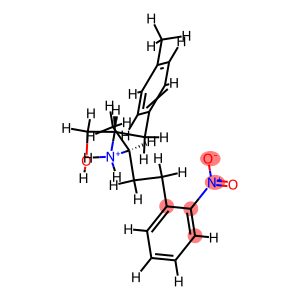
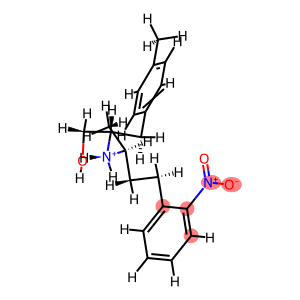

In [48]:
draw_smarts_matches(one_mol_sdf, one_mol_mol2, smarts)
display_side_by_side(image1, image2)

It is tempting to think that is is only due to the difference in aromaticity shown. That may be true here, but molecule 3 in the dataset has almost entirely different smarts patterns despite appearing identical visually. 